### $$ 1D Heat Equation$$
$$ u_t=0.003u_{xx} $$
\
Boundary condition
\
$u(0,t)=u(1,t)=0$
\
\
Initial condition
\
$u(x,0)=50x(1-x)$ for $0<x<1$

- Importing Libraries

In [40]:
import torch 
import torch.autograd as autograd
from torch import Tensor
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import math 
import time
from pyDOE import lhs
import scipy.io


- Set seed values for Random number generation

In [41]:
# Random number 
torch.set_default_dtype(torch.float)
torch.manual_seed(987)
np.random.seed(987)

- Check for device='GPU'

In [42]:
if torch.cuda.current_device()==0:
    device=torch.cuda.get_device_name()
    
print(device)

NVIDIA GeForce RTX 3060 Laptop GPU


- Generating the coordinates

In [43]:
data_x=np.linspace(0,1,200)
data_t=np.linspace(0,8,100)

# Generate meshgrid for x and t coordinates
X,T=np.meshgrid(data_x,data_t)

# Flatten the grid structure to a matrix of size [ 200*100 X 2 ]
X_u_test=np.hstack((X.flatten()[:,None],T.flatten()[:,None]))

# Convert the X_u_test data tensor (for calculation in PyTorch)
X_u_test_tensor=torch.from_numpy(X_u_test).float()

- Setting up the upper and lower limit from the data, for feature scaling

In [44]:
lb=X_u_test[0]
ub=X_u_test[-1]
print(lb,ub)

[0. 0.] [1. 8.]


- Initial Condition

In [45]:
#initial condition
initial_condition=np.hstack((X[0,:][:,None],T[0,:][:,None]))

initial_condition_u=[]

for i in data_x:
    initial_condition_u.append(50*i*(1-i))

initial_condition_u=np.array(initial_condition_u)
initial_condition_u=initial_condition_u[:,None]

- Boundary condition

In [46]:
# Boundary condition
#1
boundary_condition1=np.hstack((X[:,0][:,None],T[:,0][:,None]))
boundary_condition1_u=np.zeros((len(boundary_condition1),1),order="F")

#2
boundary_condition2=np.hstack((X[:,-1][:,None],T[:,-1][:,None]))
boundary_condition2_u=np.zeros((len(boundary_condition2),1),order="F")

- Stack the initial condition and both the boundary condition

In [47]:
all_x_train=np.vstack([initial_condition,boundary_condition1,boundary_condition2])
#print(all_x_train)

all_u_train=np.vstack([initial_condition_u,boundary_condition1_u,boundary_condition2_u])
#print(all_u_train)

- N_u $\to$ Number of point selected from initial and Boundary (all_x_train)
- N_f $\to$ Number of points randomly generated inside the domain. (lhs is used $\to$ lathin hypercube sampling)

In [48]:
N_u=150
N_f=5000

idx=np.random.choice(all_x_train.shape[0],N_u,replace=False)
#print(idx)

# #N_u are considered 
X_u_train=all_x_train[idx,:]
u_train=all_u_train[idx,:]

In [49]:
X_f_train=lb+(ub-lb)*lhs(2,N_f) # lathin hypercube sampling 
# random #N_f points are generated in 2D

#print(X_f_train)

'''
 Vertically stack the random points inside the domain(X_f_train) 
 and 
 the points of initial and boudnary condition(X_u_train)
'''

X_f_train=np.vstack((X_f_train,X_u_train))
print(X_f_train)
print((X_f_train.shape))
print(type(X_f_train))

[[0.52068364 0.60140052]
 [0.24600795 6.50121637]
 [0.05751584 7.42695767]
 ...
 [1.         3.07070707]
 [1.         6.46464646]
 [0.33165829 0.        ]]
(5150, 2)
<class 'numpy.ndarray'>


- Plotting the random points and boundary/Initial points

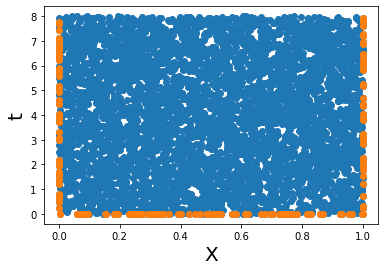

(150, 2) (150, 1) (5150, 2)


In [50]:
plt.scatter(X_f_train[:,0],X_f_train[:,1])
plt.scatter(X_u_train[:,0],X_u_train[:,1])

plt.xlabel("X",size=20)
plt.ylabel("t",size=20)

plt.show()

# Printing the number of data points considered at boundary/initial with its actual values at boudnary/Initial
# Printing the numher of random data points considered inside the domain.        
print(X_u_train.shape,u_train.shape,X_f_train.shape)

- Convert the data into tensor

In [51]:
X_f_train=torch.from_numpy(X_f_train).float()
X_u_train=torch.from_numpy(X_u_train).float()
u_train=torch.from_numpy(u_train).float()

- PINN Class

In [52]:
class PINN(nn.Module):
    
    def __init__(self,layers):
        super().__init__()
        # Define the activation function
        self.activation=nn.Tanh()
        
        # Define the loss function used (Mean square Loss)
        self.loss_function=nn.MSELoss(reduction="mean")
        
        # Linear List for data storage
        self.linears=nn.ModuleList([nn.Linear(layers[i],layers[i+1])for i in range(len(layers)-1)])
        
        # iter for counting purpose
        self.iter=0
        
        # Setting initial values of weight and bias
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data,gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)
     
    # Forward Pass
    def forward(self,x):
        
        if torch.is_tensor(x)!=True:
            x=torch.from_numpy(x)
            
        u_b=torch.from_numpy(ub).float()
        l_b=torch.from_numpy(lb).float()
        
        # Feature scaling
        x=(x-l_b)/(u_b-l_b)
        a=x.float()
        
        # Forward Pass
        for i in range(len(layers)-2):
            z=self.linears[i](a)
            a=self.activation(z)
        
        a=self.linears[-1](a)
        
        return a
    
    # Loss function for Boundary and Initial Condition
    def loss_BC(self,x,y):
        
        loss_u=self.loss_function(self.forward(x),y) # MSE loss for U_pred and U_True
        
        return loss_u
    
    # Loss function for Domain + Boundary/Initial Points (PDE Loss)
    def loss_PDE(self,x_to_train_f):
        
        K=0.003 # As per equation
        
        g=x_to_train_f.clone()
        g.requires_grad=True
        
        # Forward Pass
        u=self.forward(g)
        
        # Calculating Gradient of U
        u_x_t=autograd.grad(u,g,torch.ones([x_to_train_f.shape[0],1]),retain_graph=True,create_graph=True)[0]
        u_xx_tt=autograd.grad(u_x_t,g,torch.ones(x_to_train_f.shape),create_graph=True)[0]
        
        u_x=u_x_t[:,[0]]
        u_t=u_x_t[:,[1]]
        
        u_xx=u_xx_tt[:,[0]]
        
        # Partial Differential Equation
        f=u_t-K*u_xx
        
        # MSE Loss function for PDE and Zeros. 
        loss_f=self.loss_function(f,torch.zeros(x_to_train_f.shape[0],1))
        
        return loss_f
    
    # Loss function which calls the Loss_BC and Loss_PDE and return SUM OF BOTH THE LOSS
    def loss(self,x,y,x_to_train_f):
        
        loss_u=self.loss_BC(x,y)
        loss_f=self.loss_PDE(x_to_train_f)
        
        loss_val=loss_u+loss_f # Sum of Both the Loss
        
        return loss_val
    
    # Closure Function
    def closure(self):
        
        optimizer.zero_grad()
        
        # Call the loss function 
        loss=self.loss(X_u_train,u_train,X_f_train)
        
        loss.backward() # Backward Prop.
        
        self.iter+=1
        
        # Print the Total Loss per 100 iteration 
        if self.iter%100==0:
            print(loss)
        return loss
    
    # Test function returns the predicted the velocity (U_pred) 
    def test(self):
        
        u_pred=self.forward(X_u_test_tensor)
        u_pred=u_pred.detach().numpy()
        
        u_pred=np.reshape(u_pred,(20000,1),order="F")
        
        return u_pred
    
    
        

- MAIN Function

In [53]:
layers=np.array([2,40,40,40,40,1]) # Define the Number of neurons per layer

# Create Object passing Layers information to class PINN 
pin=PINN(layers)

print(pin) # Print Information of PINN 

params=list(pin.parameters())

# Optimization by LBFGS 
optimizer=torch.optim.LBFGS(pin.parameters(),lr=0.1,max_iter=1000,
                            max_eval=None,tolerance_grad=1e-15,
                            tolerance_change=1e-09,history_size=100,
                            line_search_fn="strong_wolfe")

# Calculating the Time
start_time=time.time()
optimizer.step(pin.closure) # Update the weights and bias terms
elapsed=time.time()-start_time

# Print the time for training
print("training time:",elapsed)

PINN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=40, bias=True)
    (1): Linear(in_features=40, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): Linear(in_features=40, out_features=40, bias=True)
    (4): Linear(in_features=40, out_features=1, bias=True)
  )
)
tensor(0.0431, grad_fn=<AddBackward0>)
tensor(0.0009, grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(0.0001, grad_fn=<AddBackward0>)
tensor(8.1128e-05, grad_fn=<AddBackward0>)
tensor(7.2486e-05, grad_fn=<AddBackward0>)
tensor(6.5030e-05, grad_fn=<AddBackward0>)
tensor(5.6374e-05, grad_fn=<AddBackward0>)
tensor(4.6829e-05, grad_fn=<AddBackward0>)
tensor(4.2824e-05, grad_fn=<AddBackward0>)
training time: 41.35699939727783


- Print Plots

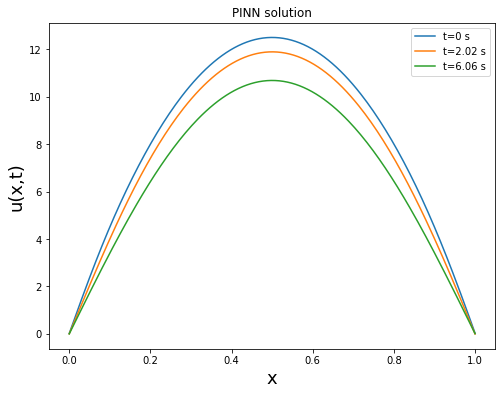

In [54]:
ax=plt.figure(figsize=(8,6))
u_val_t0=[]
x_value_t0=X_u_test[0:200]
x_value_0=x_value_t0[:,0]
u_pred=pin.test()
u_value_t0=u_pred[0:200,[0]]
#print(u_value_t0)
plt.plot(x_value_0,u_value_t0,label="t=0 s")


x_value_t2=X_u_test[5000:5200]
#print(x_value_t2)
x_value_2=x_value_t2[:,0]
#print(x_value_2)
u_value_t2=u_pred[5000:5200,[0]]
plt.plot(x_value_2,u_value_t2,label="t=2.02 s")


x_value_t6=X_u_test[15000:15200]
#print(x_value_t6)
x_value_6=x_value_t6[:,0]
u_value_t6=u_pred[15000:15200,[0]]
plt.plot(x_value_6,u_value_t6,label="t=6.06 s")

plt.xlabel("x",fontsize=18)
plt.ylabel("u(x,t)",fontsize=18)
plt.legend()
plt.title("PINN solution")
plt.show()

### Analytical solution
Sol^n by seperation of variables
\
$f(x)=\sum_{n=1}^{inf} b_n sin(n \pi x)$
\ 
where $b_n$ can be defined as,


$b_n={\frac{400}{\pi^3 n^3}}$ if n is odd
\
$b_n=0$ if n is even

In [55]:
N=np.linspace(1,100,100)
#print(N)
n=[]
for i in N:
    if i%2!=0:
        n.append(i)
print(n)

# for t=0
u0=[]

for j in data_x:
    A=0
    for i in n:
        A+=(400*math.sin(i*math.pi*j)*(math.exp(-((i**2)*(math.pi**2)*0.003*0))))/(math.pi*math.pi*math.pi*i*i*i)
    u0.append(A)
#print(u0)

u2=[]
for j in data_x:
    A=0
    for i in n:
        A+=(400*math.sin(i*math.pi*j)*(math.exp(-((i**2)*(math.pi**2)*0.003*2.0202))))/(math.pi*math.pi*math.pi*i*i*i)
    u2.append(A)
#print(u2)

u6=[]
for j in data_x:
    A=0
    for i in n:
        A+=(400*math.sin(i*math.pi*j)*(math.exp(-((i**2)*(math.pi**2)*0.003*6.0606))))/(math.pi*math.pi*math.pi*i*i*i)
    u6.append(A)
#print(u6)

[1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 27.0, 29.0, 31.0, 33.0, 35.0, 37.0, 39.0, 41.0, 43.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 59.0, 61.0, 63.0, 65.0, 67.0, 69.0, 71.0, 73.0, 75.0, 77.0, 79.0, 81.0, 83.0, 85.0, 87.0, 89.0, 91.0, 93.0, 95.0, 97.0, 99.0]


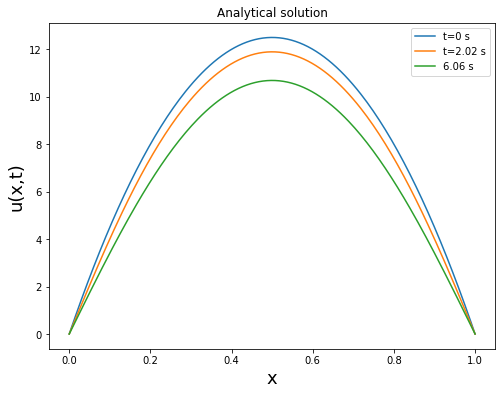

In [56]:
ax=plt.figure(figsize=(8,6))
plt.plot(data_x,u0,label="t=0 s")
plt.plot(data_x,u2,label="t=2.02 s")
plt.plot(data_x,u6,label="6.06 s")

plt.xlabel("x",fontsize=18)
plt.ylabel("u(x,t)",fontsize=18)
plt.title("Analytical solution")
plt.legend()
plt.show()

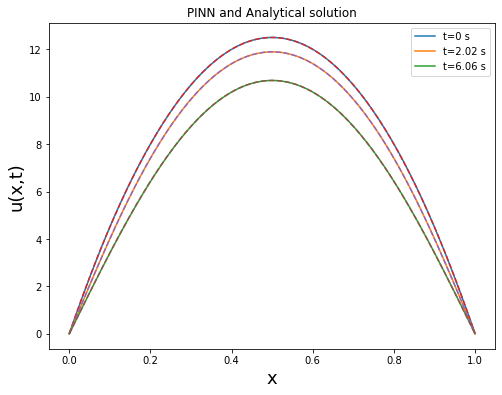

In [57]:
ax=plt.figure(figsize=(8,6))

plt.plot(x_value_0,u_value_t0,label="t=0 s")
plt.plot(x_value_2,u_value_t2,label="t=2.02 s")
plt.plot(x_value_6,u_value_t6,label="t=6.06 s")
plt.plot(data_x,u0,linestyle="dashed")
plt.plot(data_x,u2,linestyle="dashed")
plt.plot(data_x,u6,linestyle="dashed")

plt.xlabel("x",fontsize=18)
plt.ylabel("u(x,t)",fontsize=18)
plt.title("PINN and Analytical solution")
plt.legend()
plt.savefig("heat_1d")
plt.show()


---
---